<a href="https://colab.research.google.com/github/scotthou94/applied_deep_learning/blob/master/sh3658_hw4_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import string
import time

In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [3]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), int(row[1]), int(row[2]), int(row[3])
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 174, 182, 87)


In [4]:
# In this experiment, we will train a char-baed RNN to generate a line of text
# that resembles this dataset (we'll treat each line as a string)
sentences = []
for row in colors_rgb:
  line = ' '.join([str(part) for part in row])
  sentences.append(line)
print(sentences[0])

parakeet 174 182 87


In [43]:
print(sentences[:10])

['parakeet 174 182 87', 'saddle brown 88 52 1', 'cucumber crush 222 237 215', 'pool blue 134 194 201', 'distance 98 110 130', 'light urple 179 111 246', 'east side 172 145 206', 'florida seashells 250 228 199', 'paris 145 167 189', 'powder blush 247 215 215']


In [5]:
# vocabulary for our char-based RNN
chars = set()
for sentence in sentences:
  for char in sentence:
    chars.add(char)
    
# add a special char for padding
chars.add('<pad>')

vocab = sorted(set(chars))

# Create a mapping from unique characters to indices
char2idx = {u : i for i, u in enumerate(vocab)}
idx2char = {i : u for i, u in enumerate(vocab)}

# Vocab size
vocab_size = len(vocab)
print('vocab size:', vocab_size)
print(vocab)

vocab size: 38
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
# vectorize the text
text_int = []
for sentence in sentences:
  int_sentence = [] 
  for c in sentence:
    int_sentence.append(char2idx[c])
  text_int.append(int_sentence)
print('Vectorized sentence', text_int[0])

Vectorized sentence [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8]


In [48]:
print(''.join([idx2char[i] for i in text_int[0]]).replace('<pad>', ''))

parakeet 174 182 87


In [7]:
# pad sentences to max_length
max_length = 40
for sentence in text_int:
  while (len(sentence) < max_length):
    sentence.append(char2idx['<pad>'])
print('Padded sentences', text_int[0])

Padded sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [8]:
# truncate all sentences to max_length
for i in range(len(text_int)):
  sentence = text_int[i]
  if len(sentence) > max_length:
    text_int[i] = sentence[:max_length]
print("Truncated sentences", text_int[0])

Truncated sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [9]:
# Create training examples / targets
input_text = []
target_text = []

for i in range(len(text_int)):
  inps = text_int[i][:max_length-1]
  targ = text_int[i][1:max_length]
  input_text.append(inps)
  target_text.append(targ)
  
print("First training example, target")  
print(input_text[0])
print(target_text[0])

First training example, target
[27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [50]:
print(''.join([idx2char[i] for i in text_int[0]]).replace('<pad>', ''))
print(''.join([idx2char[i] for i in target_text[0]]).replace('<pad>', ''))

parakeet 174 182 87
arakeet 174 182 87


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((input_text, target_text))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [0]:
class Model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, units):
    super(Model, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    if tf.test.is_gpu_available():
      self.gru = tf.keras.layers.CuDNNGRU(self.units, return_sequences=True, stateful=True)
    else:
      self.gru = tf.keras.layers.GRU(self.units, return_sequences=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
        
  def call(self, x):
    embedding = self.embedding(x)
    x = self.gru(embedding)
    predictions = self.fc(x)
    return predictions

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
# Here, this is basically just a trick to avoid having 
# to one-hot encode the characters
# I don't think it will add much otherwise
# this would be more useful if we had a much larger vocabulary
embedding_dim = 128

# Number of RNN units
units = 38

model = Model(vocab_size, embedding_dim, units)

In [0]:
optimizer = tf.train.AdamOptimizer()

# Using sparse_softmax_cross_entropy so that we don't have to create one-hot vectors
def loss_function(labels, logits):
    return tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

In [222]:
model.build(tf.TensorShape([BATCH_SIZE, max_length]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  4864      
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       multiple                  19152     
_________________________________________________________________
dense_7 (Dense)              multiple                  1482      
Total params: 25,498
Trainable params: 25,498
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Checkpoint instance
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [56]:
dataset

<BatchDataset shapes: ((64, 39), (64, 39)), types: (tf.int32, tf.int32)>

In [223]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 39, 38) # (batch_size, sequence_length, vocab_size)


In [225]:
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch, (input_seq, target_seq)) in enumerate(dataset):
          with tf.GradientTape() as tape:
              predictions = model(input_seq)
              loss = loss_function(target_seq, predictions)
              
          grads = tape.gradient(loss, model.variables)
          optimizer.apply_gradients(zip(grads, model.variables))

          if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                            batch,
                                                            loss))

    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time for epoch {} sec\n'.format(time.time() - start))
    checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1 Batch 0 Loss 3.6358
Epoch 1 Batch 100 Loss 1.5828
Epoch 1 Batch 200 Loss 1.3055
Epoch 1 Loss 1.2961
Time for epoch 6.6653382778167725 sec

Epoch 2 Batch 0 Loss 1.2968
Epoch 2 Batch 100 Loss 1.1676
Epoch 2 Batch 200 Loss 1.1032
Epoch 2 Loss 1.1133
Time for epoch 6.239501714706421 sec

Epoch 3 Batch 0 Loss 1.1667
Epoch 3 Batch 100 Loss 1.1006
Epoch 3 Batch 200 Loss 1.1153
Epoch 3 Loss 1.1234
Time for epoch 6.860024452209473 sec

Epoch 4 Batch 0 Loss 1.1350
Epoch 4 Batch 100 Loss 1.1003
Epoch 4 Batch 200 Loss 1.0245
Epoch 4 Loss 1.0905
Time for epoch 6.363661527633667 sec

Epoch 5 Batch 0 Loss 1.1670
Epoch 5 Batch 100 Loss 1.0744
Epoch 5 Batch 200 Loss 1.0630
Epoch 5 Loss 1.0345
Time for epoch 6.275617837905884 sec

Epoch 6 Batch 0 Loss 1.0953
Epoch 6 Batch 100 Loss 1.0254
Epoch 6 Batch 200 Loss 1.0371
Epoch 6 Loss 1.0535
Time for epoch 6.408428430557251 sec

Epoch 7 Batch 0 Loss 1.0485
Epoch 7 Batch 100 Loss 1.0264
Epoch 7 Batch 200 Loss 1.0052
Epoch 7 Loss 1.0051
Time for epoch 

In [226]:
!ls {checkpoint_dir}

checkpoint		     ckpt-61.data-00000-of-00001
ckpt-46.data-00000-of-00001  ckpt-61.index
ckpt-46.index		     ckpt-62.data-00000-of-00001
ckpt-47.data-00000-of-00001  ckpt-62.index
ckpt-47.index		     ckpt-63.data-00000-of-00001
ckpt-48.data-00000-of-00001  ckpt-63.index
ckpt-48.index		     ckpt-64.data-00000-of-00001
ckpt-49.data-00000-of-00001  ckpt-64.index
ckpt-49.index		     ckpt-65.data-00000-of-00001
ckpt-50.data-00000-of-00001  ckpt-65.index
ckpt-50.index		     ckpt-66.data-00000-of-00001
ckpt-51.data-00000-of-00001  ckpt-66.index
ckpt-51.index		     ckpt-67.data-00000-of-00001
ckpt-52.data-00000-of-00001  ckpt-67.index
ckpt-52.index		     ckpt-68.data-00000-of-00001
ckpt-53.data-00000-of-00001  ckpt-68.index
ckpt-53.index		     ckpt-69.data-00000-of-00001
ckpt-54.data-00000-of-00001  ckpt-69.index
ckpt-54.index		     ckpt-70.data-00000-of-00001
ckpt-55.data-00000-of-00001  ckpt-70.index
ckpt-55.index		     ckpt-71.data-00000-of-00001
ckpt-56.data-00000-of-00001  ckpt-71.index
ck

In [0]:
# This is a hack to let us use the model with a different 
# batch size later
model = Model(vocab_size, embedding_dim, units)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [0]:
def evaluate(model, num_generate=max_length, starting_string=''):
  # Evaluation step (generating text using the learned model)

  # You can change the start string to experiment
  if starting_string == '':
    choice = np.random.choice([i for i in range(12, vocab_size)])
    starting_string = idx2char[choice]

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.2

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.multinomial(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  generated_color = starting_string + ''.join(text_generated).replace('<pad>', '')
  print('Generated text: ', generated_color)

  try:
    parts = generated_color.split()
    r = float(parts[-3])
    g = float(parts[-2])
    b = float(parts[-1])
    plt.figure(figsize=(3,3))
    plt.clf()
    _ = plt.imshow([[(r, g, b)]])
    _ = plt.axis('off')
    _ = plt.title(generated_color, fontsize=18)
  except:

    print('unable to parse color')

Generated text:  layioba 228 219 239
Generated text:  uander rossse 40 82 75
Generated text:  gamy dark migh 238 116 66
Generated text:  wridowoon colnice 88 140 164
Generated text:  moingoonthate dung 234 104 68


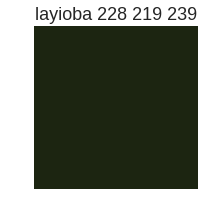

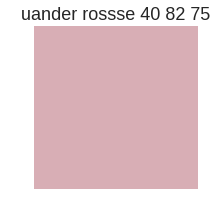

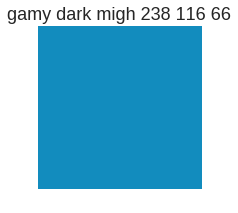

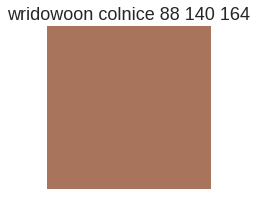

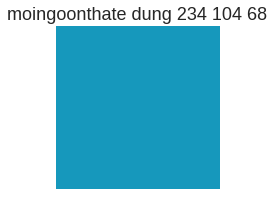

In [230]:
for i in range(5):
  evaluate(model, num_generate=30)